In [1]:
import warnings 
warnings.filterwarnings('ignore',category=DeprecationWarning)

In [2]:
import os 
import tensorflow as tf 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy,SparseCategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LearningRateScheduler

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D,BatchNormalization,MaxPool2D,Input,InputLayer,Dropout,GlobalAveragePooling2D,Activation,Add,Layer
from tensorflow.keras.regularizers import L1,L2
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import CategoricalAccuracy,TopKCategoricalAccuracy

from tensorflow.keras.layers import MaxPooling2D,MaxPool2D,Dense
from tensorflow.keras.layers import LayerNormalization

In [3]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "HIDDEN_DIM" : 768,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

In [4]:
train_dir = r"EmotionsDatset\Emotions Dataset\Emotions Dataset\train"
val_dir = r"EmotionsDatset\Emotions Dataset\Emotions Dataset\test"
CLASS_NAME = ["angry","happy","sad"]

In [5]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=CLASS_NAME,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=99
) 

val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=CLASS_NAME,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=99
)

Found 6799 files belonging to 3 classes.
Found 2278 files belonging to 3 classes.


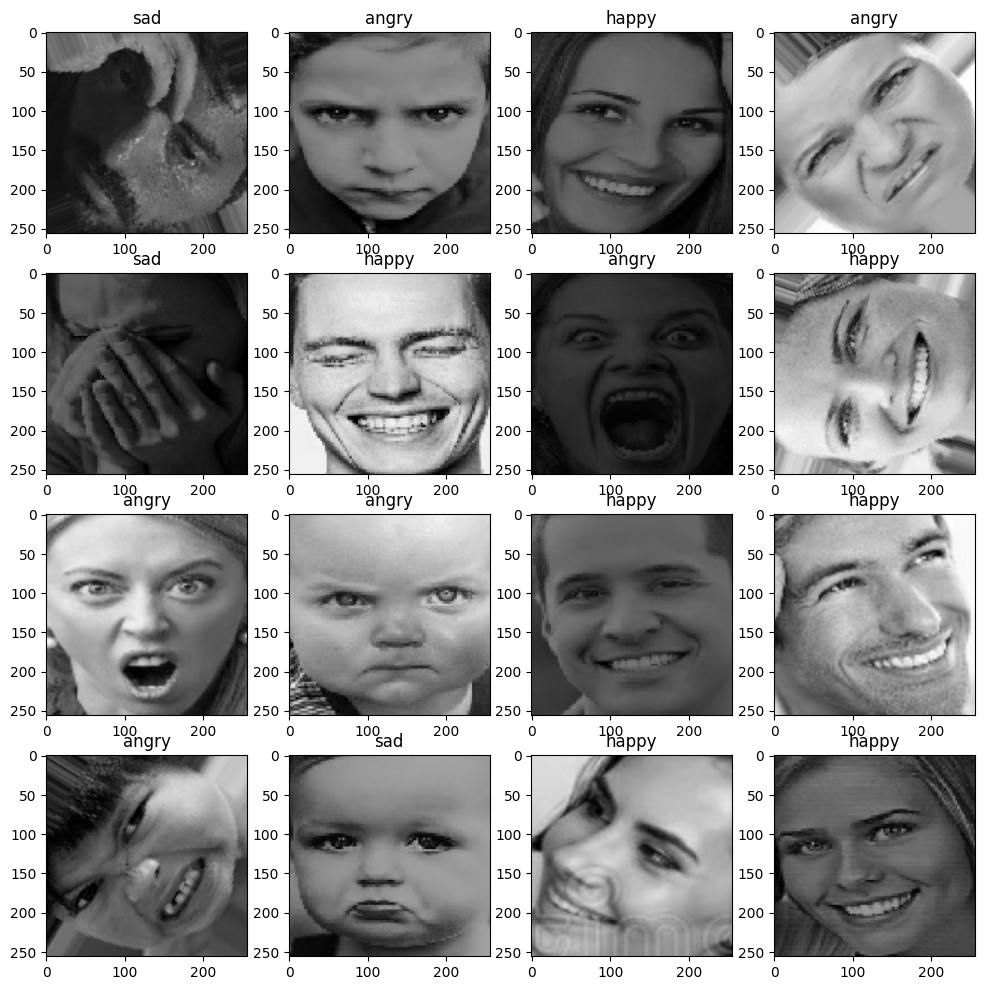

In [6]:
plt.figure(figsize=(12,12))
for image,label in train_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(image[i]/255.0)

        plt.title(CLASS_NAME[tf.argmax(label[i],axis = 0).numpy()])
        # plt.axis('off')

In [7]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

In [9]:
# !wandb login

In [10]:
# import wandb
# from wandb.integration.keras import WandbCallback

# wandb.init(project='Emotion-Detection-Colab')

In [19]:
# wandb.config = CONFIGURATION

In [8]:
class PatchEncodeLayer(Layer):
    def __init__(self,N_PATCHES,HIDDEN_SIZE):
        super(PatchEncodeLayer,self).__init__(name = "patch_encoder")
        self.LinearProj = Dense(HIDDEN_SIZE)
        self.postional_embed = tf.keras.layers.Embedding(N_PATCHES,HIDDEN_SIZE)
        self.n_patches = N_PATCHES

    def call(self,x):
        patches = tf.image.extract_patches(
            images=x,
            sizes=[1, CONFIGURATION['PATCH_SIZE'], CONFIGURATION['PATCH_SIZE'], 1],
            strides=[1, CONFIGURATION['PATCH_SIZE'],CONFIGURATION['PATCH_SIZE'], 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
            )

        patches = tf.reshape(patches,(tf.shape(patches)[0],256,patches.shape[-1]))
        embed_imput = tf.range(start = 0,limit = self.n_patches,delta =1)
        out = self.LinearProj(patches) + self.postional_embed(embed_imput)

        return out

In [9]:
patch_enc = PatchEncodeLayer(256,768)
patch_enc(tf.zeros([32,256,256,3]))

<tf.Tensor: shape=(32, 256, 768), dtype=float32, numpy=
array([[[ 0.01262495,  0.01754076,  0.02385039, ..., -0.0262883 ,
          0.04646996,  0.0437195 ],
        [ 0.02118156, -0.01102304,  0.04640331, ...,  0.01492831,
          0.04923785,  0.00827826],
        [ 0.02086491, -0.01170429, -0.00658787, ...,  0.02539415,
          0.00901639, -0.02875986],
        ...,
        [-0.00079308, -0.04216062,  0.03576824, ...,  0.04040699,
         -0.01701056, -0.04650931],
        [-0.04395571,  0.04653433, -0.00019096, ..., -0.02326617,
         -0.04269689,  0.03574857],
        [-0.02080875,  0.00399185,  0.02176564, ...,  0.0459541 ,
          0.04616806, -0.02001834]],

       [[ 0.01262495,  0.01754076,  0.02385039, ..., -0.0262883 ,
          0.04646996,  0.0437195 ],
        [ 0.02118156, -0.01102304,  0.04640331, ...,  0.01492831,
          0.04923785,  0.00827826],
        [ 0.02086491, -0.01170429, -0.00658787, ...,  0.02539415,
          0.00901639, -0.02875986],
        ...

In [10]:
# Transformation encoder

class TransformerEncoder(Layer):
    def __init__(self,N_HEADS,HIDDEN_SIZE):
        super(TransformerEncoder,self).__init__(name = 'transformer_encoder')
        # 1. Layer norm
        self.layer_norm1 = LayerNormalization()
        self.layer_norm2 = LayerNormalization()
        # 2. Multi head attention

        self.multiHead = tf.keras.layers.MultiHeadAttention(
            N_HEADS,HIDDEN_SIZE
        )
        # 3 dense layers

        self.dense_1 = Dense(HIDDEN_SIZE,activation = tf.nn.gelu)
        self.dense_2 = Dense(HIDDEN_SIZE,activation = tf.nn.gelu)


    def call(self,input):
        x = self.layer_norm1(input)
        x = self.multiHead(x,x)

        x = Add()([x,input])

        y = self.layer_norm2(x)


        y = self.dense_1(y)

        out = self.dense_2(y)

        output = Add()([out,x])

        return out


In [11]:
transformer_1 = TransformerEncoder(8,768)
transformer_1(tf.zeros([1,256,768]))

<tf.Tensor: shape=(1, 256, 768), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]],
      shape=(1, 256, 768), dtype=float32)>

In [12]:
from tensorflow.keras.layers import Flatten

In [13]:
#  Summing everything and making a a ViT

class ViT(Model):
    def __init__(self,N_HEADS,HIDDEN_SIZE,N_PATCHES,N_LAYERS,N_DENSE_UNITS):
        super(ViT,self).__init__(name = 'Vision_Transformer')
        self.n_layers = N_LAYERS
        self.patch_encoder = PatchEncodeLayer(N_PATCHES,HIDDEN_SIZE)
        self.transformer_encoder = [TransformerEncoder(N_HEADS,HIDDEN_SIZE) for _ in range(N_LAYERS)]
        self.dense_1 = Dense(N_DENSE_UNITS,activation=tf.nn.gelu)
        self.dense_2 = Dense(N_DENSE_UNITS,activation=tf.nn.gelu)
        self.dense_3 = Dense(CONFIGURATION['NUM_CLASSES'],activation='softmax')
    def call(self,input ,training=True):

        x = self.patch_encoder(input)
        for i in range(self.n_layers):
            x = self.transformer_encoder[i](x)

        x = Flatten()(x)

        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.dense_3(x)



In [14]:
vit_model =  ViT(N_HEADS=4,HIDDEN_SIZE=768,N_PATCHES = 256,N_LAYERS=2,N_DENSE_UNITS=128)

vit_model(tf.zeros([32,256,256,3]))

<tf.Tensor: shape=(32, 3), dtype=float32, numpy=
array([[0.2592173 , 0.29508674, 0.44569597],
       [0.2592173 , 0.29508674, 0.44569597],
       [0.2592173 , 0.29508674, 0.44569597],
       [0.2592173 , 0.29508674, 0.44569597],
       [0.2592173 , 0.29508674, 0.44569597],
       [0.2592173 , 0.29508674, 0.44569597],
       [0.2592173 , 0.29508674, 0.44569597],
       [0.2592173 , 0.29508674, 0.44569597],
       [0.2592173 , 0.29508674, 0.44569597],
       [0.2592173 , 0.29508674, 0.44569597],
       [0.2592173 , 0.29508674, 0.44569597],
       [0.2592173 , 0.29508674, 0.44569597],
       [0.2592173 , 0.29508674, 0.44569597],
       [0.2592173 , 0.29508674, 0.44569597],
       [0.2592173 , 0.29508674, 0.44569597],
       [0.2592173 , 0.29508674, 0.44569597],
       [0.2592173 , 0.29508674, 0.44569597],
       [0.2592173 , 0.29508674, 0.44569597],
       [0.2592173 , 0.29508674, 0.44569597],
       [0.2592173 , 0.29508674, 0.44569597],
       [0.2592173 , 0.29508674, 0.44569597],
      

In [15]:
vit_model.summary()

Model: "Vision_Transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ patch_encoder                   │ ?                      │       787,200 │
│ (PatchEncodeLayer)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder             │ ?                      │    10,631,424 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder             │ ?                      │    10,631,424 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (32, 128)              │    25,165,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (32, 128)              │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (32, 3)                │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,232,899 (180.18 MB)

 Trainable params: 47,232,899 (180.18 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]
vit_model.compile(
    optimizer = Adam(learning_rate=CONFIGURATION['LEARNING_RATE']),
    loss = 'categorical_crossentropy',
    metrics = metrics
)
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,LearningRateScheduler,ModelCheckpoint,CSVLogger,TensorBoard
earlystop = EarlyStopping(
    monitor = 'val_loss',
    patience = 10,
    restore_best_weights = True
)


reduced_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

In [17]:
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint
# callbacks = [
#     earlystop,
#     WandbMetricsLogger(log_freq="epoch"),
#     WandbModelCheckpoint(f"models/{run.id}")   # unique dir per run
# ]

In [33]:
# import wandb
# from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint
# # Login (if not already done)

# # Initialize the run
# run = wandb.init(project="Emotion-Detection-Colab")

# # Define callbacks
# checkpoint_dir = f"models/{run.id}"
# os.makedirs(checkpoint_dir, exist_ok=True)

# callbacks = [
#     earlystop,
#     WandbMetricsLogger(log_freq="epoch"),
#     WandbModelCheckpoint(f"{checkpoint_dir}/model.keras")  # filename required
# ]

# history = vit_model.fit(
#     train_dataset,
#     validation_data=val_dataset,
#     epochs=CONFIGURATION['N_EPOCHS'],
#     verbose=1,
#     callbacks=callbacks
# )


In [34]:
# vit_model.save("Vit-Model.keras")

### Google transformer Finetuning


In [18]:
from tensorflow.keras.layers import Resizing,Rescaling,Permute

In [19]:
resize_rescale_hf = tf.keras.Sequential([
       Resizing(224, 224),
       Rescaling(1./255),
       Permute((3,1,2))
])

In [20]:
from transformers import ViTFeatureExtractor, TFViTModel

c:\projects\HumanEmo\HumanEmoNew\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
class ViTCLSExtractor(Layer):
    def __init__(self, model_name="google/vit-base-patch16-224-in21k", **kwargs):
        super().__init__(**kwargs)
        self.vit = TFViTModel.from_pretrained(model_name, from_pt=True, name="vit_base")

    def call(self, inputs):
        outputs = self.vit(pixel_values=inputs)
        cls_token = outputs.last_hidden_state[:, 0, :]  # take [CLS] token
        return cls_token

In [22]:
from transformers import ViTFeatureExtractor, TFViTModel
from tensorflow.keras.layers import Lambda

base_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k",from_pt = True)

inputs = Input(shape = (CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"],3),dtype = tf.float32)

# Resize, rescale, and permute dimensions to match the expected input format
x = resize_rescale_hf(inputs)

# Pass through TFViTModel using Lambda to convert KerasTensor to tensor
cls_token = ViTCLSExtractor()(x)
# Add classification head
x = Dense(256, activation='relu')(cls_token)
outputs = Dense(CONFIGURATION['NUM_CLASSES'], activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.
All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [23]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 3, 224, 224)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vi_tcls_extractor               │ (None, 768)            │             0 │
│ (ViTCLSExtractor)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 197,635 (772.01 KB)

 Trainable params: 197,635 (772.01 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
earlystop = EarlyStopping(
    monitor = 'val_loss',
    patience = 10,
    restore_best_weights = True
)


reduced_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=1e-6,
    verbose=1
)
model.compile(
    optimizer = Adam(learning_rate=5e-5),#low learning rate for google transoformers
    loss = 'categorical_crossentropy',
    metrics = [CategoricalAccuracy(name ='accuracy'), TopKCategoricalAccuracy(k=2, name='top_2_accuracy')]
)

In [52]:
# history_new = model.fit(
#     train_dataset,
#     validation_data=val_dataset,
#     epochs=35,
#     verbose=1,
#     callbacks=[earlystop]
# )

In [53]:
# model.save("google-finetuned_ViT-model.keras")

In [25]:
from tensorflow.keras.models import load_model

In [26]:
finetuned_model = load_model("google-finetuned_ViT-model.keras",
                             custom_objects = {'ViTCLSExtractor':ViTCLSExtractor})

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [ ]:
finetuned_model.evaluate(val_dataset)

 2/72 ━━━━━━━━━━━━━━━━━━━━ 13:19 11s/step - accuracy: 0.7891 - loss: 0.4165 - top_2_accuracy: 0.9219

In [39]:
# import cv2

In [40]:
# test_image = cv2.imread(r"C:\projects\HumanEmo\EmotionsDatset\Emotions Dataset\Emotions Dataset\test\angry\14615.jpg_rotation_1.jpg")
# test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))

In [42]:
# model(tf.expand_dims(test_image,axis = 0))

In [43]:
# model.summary()

In [44]:
# run_new = wandb.init(project='Emotion-Detection-Colab-GoogleTransformers')
# checkpoint_dir_new = f"models/{run_new.id}"

# os.makedirs(checkpoint_dir_new, exist_ok=True)

# callbacks_new = [
#     earlystop,
#     WandbMetricsLogger(log_freq="epoch"),
#     WandbModelCheckpoint(f"{checkpoint_dir_new}/model.keras")  # filename required
# ]

# model.compile(
#     optimizer = Adam(learning_rate=5e-5),#low learning rate for google transoformers
#     loss = 'categorical_crossentropy',
#     metrics = metrics
# )

# history_new = model.fit(
#     train_dataset,
#     validation_data=val_dataset,
#     epochs=CONFIGURATION['N_EPOCHS'],
#     verbose=1,
#     callbacks=callbacks_new
# )